# Python Basics


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


csvFileAddress = input('Enter Metatrader5 CSV export File Address:')

DJ = pd.read_csv(csvFileAddress,delim_whitespace=True)

DJ.insert(7, '<ISGREEN>',value=0)
DJ.insert(8, '<SIZE>',value=0)
DJ.insert(9, '<VOLATILITY>',value=0)

DJ['<ISGREEN>'] =  DJ['<CLOSE>'] > DJ['<OPEN>']
DJ['<SIZE>'] =  DJ['<CLOSE>'] - DJ['<OPEN>']
DJ['<VOLATILITY>'] =  DJ['<HIGH>'] - DJ['<LOW>']

DJ.drop(['<TICKVOL>','<VOL>','<SPREAD>'],axis=1,inplace=True)



In [43]:
timeFrame = (int(DJ.iloc[1][1][1])-int(DJ.iloc[0][1][1]) ) * 60 + (int(DJ.iloc[1][1][3:5])-int(DJ.iloc[0][1][3:5]))
CandlesInDay = 24 * (60//timeFrame)

In [44]:
def candleToTime(j):
    minuteMult = CandlesInDay//24
    k=j//minuteMult
    sth=timeFrame*(j%minuteMult)
    return '{:02d}:{:02d}:00'.format(k,sth)

uniqueDays = DJ.drop_duplicates(subset='<DATE>')
uniqueDays = pd.DataFrame(uniqueDays)

uniqueDaysCount=uniqueDays.shape[0]


newDF = pd.DataFrame(columns=['<DATE>','<TIME>'])




for i in range(uniqueDaysCount):

    if(i%(uniqueDaysCount//10)==0):
        print((int((i)/uniqueDaysCount*10000))/100 , '%')
    for j in range(CandlesInDay):
        newDF.loc[(i*CandlesInDay)+j]=[uniqueDays.iloc[i][0],candleToTime(j)]


0.0 %
9.88 %
19.77 %
29.65 %
39.54 %
49.42 %
59.31 %
69.2 %
79.08 %
88.97 %
98.85 %


In [45]:

newestDF = newDF.merge(DJ,on=['<DATE>','<TIME>'],how='left')

# newestDF.drop(columns=['<OPEN>_x','<CLOSE>_x','<SIZE>_x','<VOLATILITY>_x','<ISGREEN>_x'],inplace=True)
newestDF['<ISGREEN>'].fillna(0,inplace=True)
newestDF['<SIZE>'].fillna(0,inplace=True)
newestDF['<VOLATILITY>'].fillna(0,inplace=True)
newestDF['<EMA30>']= newestDF['<CLOSE>'].ewm(span=30).mean()




In [46]:
newestDF.head(10)

,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<ISGREEN>,<SIZE>,<VOLATILITY>,<EMA30>
0,2019.04.11,00:00:00,NaN,NaN,NaN,NaN,0,0.00,0.00,NaN
1,2019.04.11,01:00:00,1307.92,1308.46,1307.70,1308.03,True,0.11,0.76,1308.030000
2,2019.04.11,02:00:00,1308.02,1309.15,1307.95,1308.04,True,0.02,1.20,1308.035167
3,2019.04.11,03:00:00,1308.07,1308.27,1306.96,1307.71,False,-0.36,1.31,1307.919474
4,2019.04.11,04:00:00,1307.72,1308.28,1306.57,1306.95,False,-0.77,1.71,1307.652349
5,2019.04.11,05:00:00,1306.95,1307.10,1306.28,1306.68,False,-0.27,0.82,1307.431116
6,2019.04.11,06:00:00,1306.68,1306.71,1306.21,1306.61,False,-0.07,0.50,1307.270478
7,2019.04.11,07:00:00,1306.61,1307.17,1306.02,1307.13,True,0.52,1.15,1307.246181
8,2019.04.11,08:00:00,1307.13,1308.13,1306.82,1307.83,True,0.70,1.31,1307.337278
9,2019.04.11,09:00:00,1307.83,1308.22,1306.21,1306.54,False,-1.29,2.01,1307.223305


In [47]:
list = []
for i in range(len(newestDF)):
    date = newestDF.iloc[i]["<DATE>"]
    time = newestDF.iloc[i]["<TIME>"]
    isGreen = newestDF.iloc[i]["<ISGREEN>"]
    size = newestDF.iloc[i]["<SIZE>"]
    volatility = newestDF.iloc[i]["<VOLATILITY>"]
    
    list.append([date, time, isGreen, size, volatility])


In [48]:
days = []
for i in range(uniqueDaysCount): 
    days.append(list[i*CandlesInDay: CandlesInDay*(i+1)])


In [49]:
avgMultiplier = float(input('Only calculate candles bigger than X times the average (def=1) :' )or '1')

def eachDayMatrix(day):
    
    avgCandleBodySize=0
    avgCandleVolatility=0

    for i in range(len(day)):
        avgCandleBodySize+=abs(day[i][3])
        avgCandleVolatility+=abs(day[i][4])
    
    avgCandleBodySize/=len(day)
    avgCandleVolatility/=len(day)

    ansMatrix = np.zeros((CandlesInDay,CandlesInDay),dtype=int)
    countMatrix = np.zeros((CandlesInDay,CandlesInDay),dtype=int)
    for i in range(len(day)) : 
        for j in range (i,len(day)):
            if abs(day[i][4])> avgCandleVolatility*avgMultiplier and abs(day[j][4])>0 :
                countMatrix[i][j] += 1
                ansMatrix[i][j]=1 if not(day[i][2] ^ day[j][2]) else -1
                continue
            ansMatrix[i][j]=0
            

    return [ansMatrix,countMatrix]

ansVector = []
countVector = []
for i in range(len(days)):
    countVector.append(eachDayMatrix(days[i])[1])
    ansVector.append(eachDayMatrix(days[i])[0])

final = np.sum(ansVector, axis=0)
countFinal = np.sum(countVector, axis=0)
# final-=len(days)//2
# plt.imshow(final)



<AxesSubplot:>

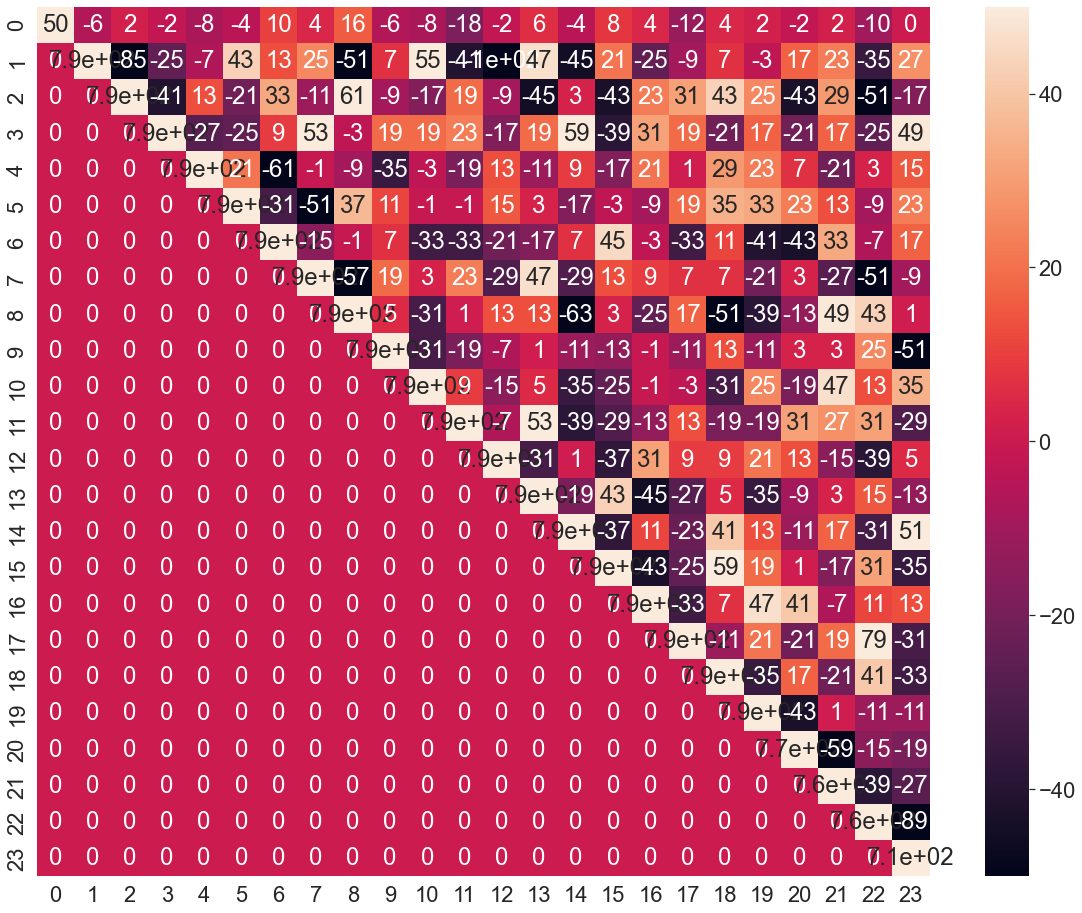

In [50]:
plt.figure(figsize=(20,16))
sns.set(font_scale=2)
sns.heatmap(final,annot=True,vmax=50,vmin=-50)



<AxesSubplot:>

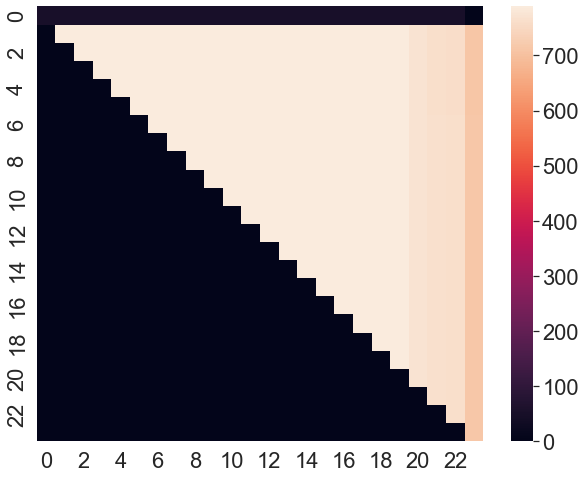

In [51]:
plt.figure(figsize=(10,8))

sns.heatmap(countFinal,annot=False,)


In [52]:
# float(input('Bias:')) 
biasPercentage = 70


consecutiveAndClose = False
consecutiveOnly = False

percentTimesCountedAtLeastMoreThan = 30

print('Averages Multiplier :',avgMultiplier)
for i in range(len(final)):
    for j in range (i,len(final)):
        percentageHigherThanAvg = int(countFinal[i][j]/uniqueDaysCount *10000) /100
        if( percentageHigherThanAvg < percentTimesCountedAtLeastMoreThan ):
            continue
        prob = int(abs(final[i][j]) / countFinal[i][j] *10000)/100 + 50.00
        if (biasPercentage<prob<100)and (not i==j):
            if(j-i==1):

                print(f"{i}-{j}",
                f"{candleToTime(i)}-{candleToTime(j)}",
                f"{prob}% ++",
                percentageHigherThanAvg,
                'Consecutive') if final[i][j]>=0 else print(f"{i}-{j}",
                f"{candleToTime(i)}-{candleToTime(j)}",
                f"{prob}% --",
                percentageHigherThanAvg,
                'Consecutive')
                continue

            if(j-i <= 120/timeFrame) and (not consecutiveOnly):

                print(f"{i}-{j}",
                f"{candleToTime(i)}-{candleToTime(j)}",
                f"{prob}% ++",
                percentageHigherThanAvg,
                'Close') if final[i][j]>=0 else print(f"{i}-{j}",
                f"{candleToTime(i)}-{candleToTime(j)}",
                f"{prob}% --",
                percentageHigherThanAvg,
                'Close')
                continue

            if not(consecutiveAndClose or consecutiveOnly): 
                
                print(f"{i}-{j}",
                f"{candleToTime(i)}-{candleToTime(j)}",
                f"{prob}% ++",
                percentageHigherThanAvg) if final[i][j]>=0 else print(f"{i}-{j}",
                f"{candleToTime(i)}-{candleToTime(j)}",
                f"{prob}% --",
                percentageHigherThanAvg)




Averages Multiplier : 0.0
